# MozzieMonitor data extraction from Ethovision output files
## Linhan Dong 2-16-2024

In [44]:
import glob
import os
import numpy as np
import csv
from pylab import *
import pandas as pd
from scipy import signal
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import xlsxwriter
import matplotlib.pyplot as plt

In [45]:
"""Set parent directory"""
#parent_directory = '/Users/donglinhan/Desktop/activityTracker-Dong/'

"""designate folder containing data to analyze"""
data_dir = 'MM0009/'

"""make a results folder within data_dir"""
path = os.path.join(data_dir, "results")
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

"""load and sort file names"""
datafiles = glob.glob(os.path.join(data_dir, '*xlsx'))
datafiles.sort(key=lambda x: int(''.join(filter(str.isdigit, x)))) 

excel_1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
total_length = 17
sheets = [excel_1]
x = 0
data = []

"""make dataframe for all raw distance_moved for every excel file and nested sheets"""
for file in datafiles:
    print(file)
    #sheet_name = index of sheets starting from 0
    df = pd.read_excel(file, sheet_name = sheets[x], usecols= 'H', header = 36)
    for column in df:
        data.append(df[column])
    x += 1

MM0009/Raw data-MM0009ESAMPM-round3-Trial     1.xlsx


In [46]:
#THIS IS TO APPLY CROP TO MM DATA
#set normalize to True (activity score) or False (raw distance moved)
normalize = False

#set bin size = 5, 15, or 30 
bin_size = 15

x=0
ind_sheet = 0
column = 1
crop = 0 #number of frames to drop before ZT16

# change name of output file here
excel_name = path + "/raw_bin15_cropped.xlsx"
print("writing to " + excel_name + "...")
wb = xlsxwriter.Workbook(excel_name)
worksheet = wb.add_worksheet()
worksheet.write(0, 0, "TS (Time Series)")

#iterating through each of the datafiles in the input folder
for datafile in range(len(datafiles)):
    #iterating through each sheet in each of the datafiles
    for sheet in sheets[x]:
        row = 1
        """This part of the script aims to calculate the periodicity"""
        """The first part is the same procedure, see above for details and comments about calculating act_score"""
        #replace all dashes(-) with NaN
        new_data = data[ind_sheet].replace('-', np.nan).astype('float')
        new_data = new_data[crop:]
        #reshape using bin_size delineated above
        new_data = new_data.values[: int(np.floor(len(new_data) / bin_size) * bin_size)].reshape((-1, bin_size))
        masked_data = np.ma.masked_array(new_data, np.isnan(new_data))
        #calculate mean of the masked_data
        mean = np.mean(masked_data, axis=1).data
        #normalize to mean
        raw_score = mean / max(mean) * 1000
        act_score = raw_score.astype(int)
        
        if normalize:
            name = "normalized"
            #gives each column name for output excel file
            column_name = datafiles[datafile][19:-5] + "_sheet"+ str(sheet + 1) + "_" + name + "_" + str(bin_size)
            #write column name to excel file -> documentation is (row, column, name)
            worksheet.write(0, column, column_name)
            #finds length of act_score to write in time series (below)
            length = len(act_score)
            #write act_score into excel file
            for score in act_score:
                worksheet.write(row, column, score)
                row +=1
            column += 1
            
        else:
            name = "raw"
            #gives each column name for output excel file
            column_name = datafiles[datafile][13:-5] + "_sheet"+ str(sheet + 1) + "_" + name + "_" + str(bin_size)
            #write column name to excel file -> documentation is (row, column, name)
            worksheet.write(0, column, column_name)
            #finds length of mean data to write in time series (below)
            length = len(mean)
            #write mean into excel file
            for me in mean:
                worksheet.write(row, column, me)
                row +=1
            column += 1
        
        
        #generates time series based on bin_size
        time = 0
        count = 1
        if bin_size == 5:
            for i in range(length):
                worksheet.write(count, 0, time)
                time += round(float(1/12),3)
                count += 1
        #i.e. if bin_size is 15, then iterate "length" (determined above) amount of times and generate the times series by incrementing the time by 0.25 
        elif bin_size == 15:
            for i in range(length):
                worksheet.write(count, 0, time)
                time += 0.25
                count += 1
        else:
            for i in range(length):
                worksheet.write(count, 0, time)
                time += 0.5
                count += 1 
        
        ind_sheet += 1
    x += 1

#close workbook to avoid extra data added
wb.close()
print("finished writing to " + excel_name)

writing to MM0009/results/raw_bin15_cropped.xlsx...
finished writing to MM0009/results/raw_bin15_cropped.xlsx


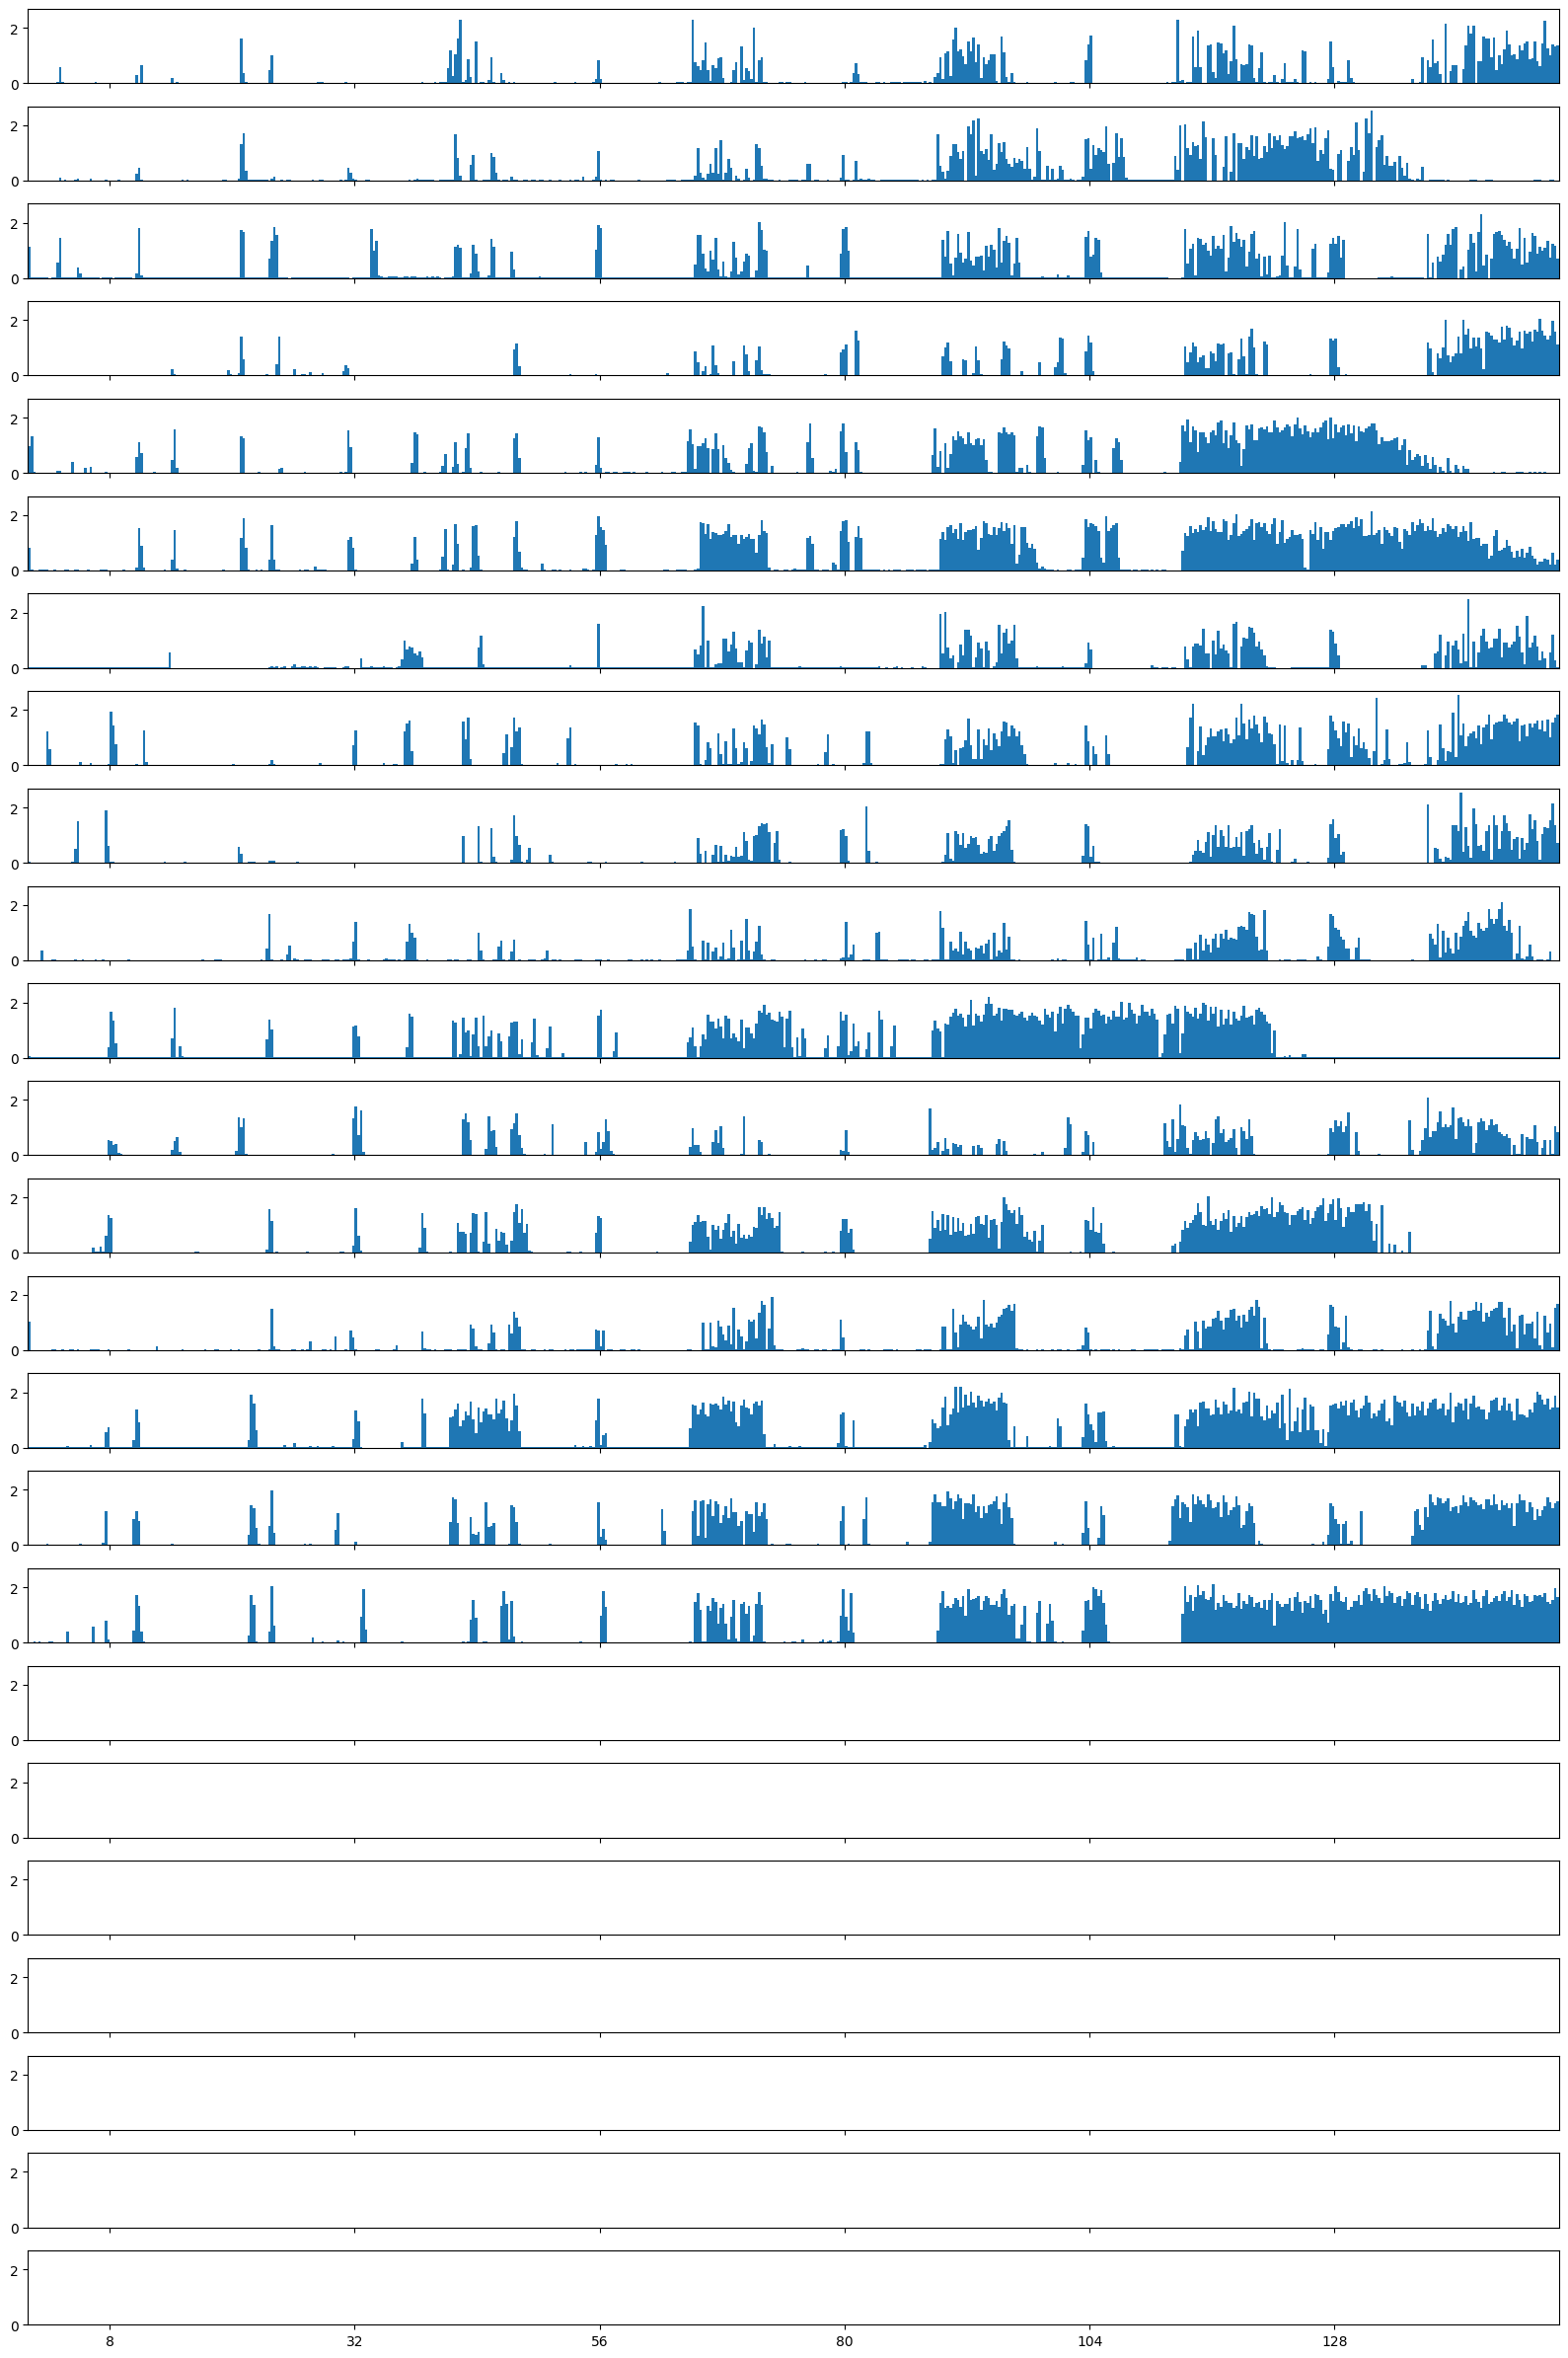

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
df = pd.read_excel('/Users/donglinhan/Desktop/activityTracker-Dong/MM0009/results/raw_bin15_cropped.xlsx', index_col=0, parse_dates=True)

# Plot all columns as stacked subplots
fig, axes = plt.subplots(nrows=24, ncols=1, figsize=(16, 24), sharex=True, sharey=True)

x_limit = (0, 150)

# Iterate through each column and plot as a subplot
for i, column in enumerate(df.columns):
    
    ax = axes[i]
    ax.bar(df.index, df[column], width=0.25, align='edge')
    ax.spines['left'].set_position(('data', 0))
    ax.set_xticks(np.arange(8, 150, 24))
    ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()])

plt.xlim(x_limit)

# Adjust layout for better appearance
plt.tight_layout()

plt.savefig('MM0009_cropped.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()